# Table of Contents

* [Introduction](#Introduction)
* [Meta-data](#Meta_data)
* [Data Reading](#Data_reading)
* [ML Modeling](#ML_modeling)
    * [Linear Regression](#Linear_Regression)
        * [First Iteration](#First_Iteration)
        * [Second Iteration](#Second_Iteration)
* [Model Export](#Model_export)

## Introduction

Vous êtes développeur AI dans une startup de la Silicon Valley qui fournit des services dans le domaine de l'investissement immobilier.
Les chargés de relation client ont mentionné que la demande a augmenté récemment et qu'il devient difficile de faire des estimations personnalisées.
De ce fait, l'entreprise vous a confier d'automatiser cette tâche avec un modèle prédictif.
Pour cela, vous avez récupéré une base de données qui contient les prix médians des logements pour les districts de Californie issus du recensement de 1990

## Meta data

`longitude`
`latitude`
`housingMedianAge` | Âge médian d'une maison dans un pâté de maisons ; un chiffre plus bas correspond à un bâtiment plus récent.
`totalRooms` | Nombre total de chambres dans un bloc
`totalBedrooms` |  Nombre total de chambres de lit dans un bloc
`population` Nombre total de personnes résidant dans un bloc
`households`| Nombre total de ménages, c'est-à-dire un groupe de personnes résidant dans une unité d'habitation, pour un bloc
`medianIncome` | Revenu médian des ménages dans un bloc de maisons (mesuré en dizaines de milliers de dollars US)
`medianHouseValue` | Valeur médiane des maisons pour les ménages d'un bloc (mesurée en dollars US)
`oceanProximity` | Situation de la maison par rapport à la mer

## Importing Libraries

In [2]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# package to import model
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Data Reading

### Reading data

In [3]:
# importing cleaned dataset w/out missing values, duplicates and capped outliers to 10th and  90th percentiles
df = pd.read_csv(r'../data/data_cleaned.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,14817.0,72000.0,INLAND
1,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,69133.0,274100.0,<1H OCEAN
2,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,15536.0,58300.0,INLAND
3,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,15284.0,200000.0,<1H OCEAN
4,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,40815.0,117900.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
16507,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,30625.0,93800.0,INLAND
16508,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,26133.0,103100.0,NEAR BAY
16509,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,44958.0,192600.0,INLAND
16510,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,25750.0,153500.0,<1H OCEAN


## Feature Engineering

### Encoding

We'll need to use either one-hot or dummy feature encoding methods since if we categorize 'ocean_proximity' feature with an ordinal encoding, it'll cause an increase of feature's weight, affecting model's predictivity performance, giving a 'preference' to some instance (individuals) which have been feature labeled with highest 'class' category.

We'll use then dummy feature encoding

In [4]:
# Using get_dummies() pandas method to return a dataframe with ocean_proximity instances as dummy variables.
dummy_ocn_prx = pd.get_dummies(df.ocean_proximity)
print(dummy_ocn_prx)

       <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0              0       1       0         0           0
1              1       0       0         0           0
2              0       1       0         0           0
3              1       0       0         0           0
4              0       1       0         0           0
...          ...     ...     ...       ...         ...
16507          0       1       0         0           0
16508          0       0       0         1           0
16509          0       1       0         0           0
16510          1       0       0         0           0
16511          0       0       0         0           1

[16512 rows x 5 columns]


In [5]:
# dropping unneeded ocean_proximity raw feature
df = df.drop(['ocean_proximity'], axis=1)
# merging encoded feature instances into the scaled dataframe
df = pd.merge(
    left=df,
    right=dummy_ocn_prx,
    left_index=True,
    right_index=True,
)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,14817.0,72000.0,0,1,0,0,0
1,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,69133.0,274100.0,1,0,0,0,0
2,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,15536.0,58300.0,0,1,0,0,0
3,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,15284.0,200000.0,1,0,0,0,0
4,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,40815.0,117900.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,30625.0,93800.0,0,1,0,0,0
16508,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,26133.0,103100.0,0,0,0,1,0
16509,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,44958.0,192600.0,0,1,0,0,0
16510,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,25750.0,153500.0,1,0,0,0,0


## Building a baseline model

### Linear regression

#### Hold-out split

In [6]:
# define X, y
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Instantiate Linear regression model

In [8]:
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
# return model's score
reg.score(X_test, y_test)

0.6562230949358678

## First Iteration : Data Cleaning / Feature Engineering

### Scaling

#### Importing scaled data set and encoded ocean_proximity categorical feature

In [27]:
X_scaled = pd.read_csv('../data/data_scd_ecd.csv')

In [9]:
X_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-0.137635,0.534564,-1.795939,-0.357368,-0.156633,-0.032827,-0.218173,-1.258403,0,1,0,0,0,72000.0
1,0.879836,-0.909979,-1.637178,-0.276515,-0.449079,-0.494784,-0.417841,1.610623,1,0,0,0,0,274100.0
2,-0.312201,0.455091,-0.287715,-0.799127,-0.767468,-0.435204,-0.744572,-1.220425,0,1,0,0,0,58300.0
3,0.620480,-0.713633,0.188566,-0.913406,-0.732092,-0.723603,-0.710862,-1.233736,1,0,0,0,0,200000.0
4,-0.830911,1.011403,-0.605236,-0.326201,-0.392477,-0.263373,-0.334862,0.114837,0,1,0,0,0,117900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.165080,1.852884,-0.684616,-0.532626,-0.616528,-0.595810,-0.651220,-0.423409,0,1,0,0,0,93800.0
16508,-1.339646,1.161000,1.617410,-0.126100,-0.083522,-0.262510,-0.111856,-0.660681,0,0,0,1,0,103100.0
16509,-0.825923,1.539666,-0.763996,-0.051119,-0.184934,-0.197750,-0.187056,0.333675,0,1,0,0,0,192600.0
16510,0.710257,-0.685584,0.823608,0.059547,0.708913,0.959301,0.704970,-0.680911,1,0,0,0,0,153500.0


#### Hold-out split

In [10]:
# define X, y
X = X_scaled.drop("median_house_value", axis=1)
y = X_scaled["median_house_value"]

# Splitting data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Instantiate Linear regression model

In [11]:
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
# return model's score
reg.score(X_test, y_test)

0.6562230949358718

### *Notes*

The score has not changed at all, even after a feature scaling treatment.

## Second Iteration :  Feature Engineering / Feature Selection

### Create new features

We could handle those coordinates features performing a clustering to categorize them per 'cluster' in addition to the current per ocean proximity categorical feature, that we'll one hot encode to get better results.

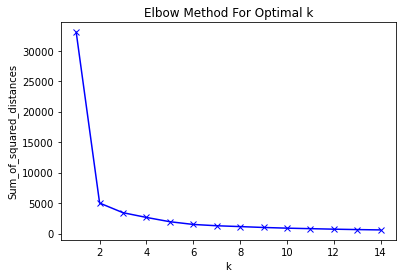

In [22]:
# importing required library
from sklearn.cluster import KMeans

# create coordinates-only dataframe
cdts_df = X_scaled[['longitude', 'latitude']]

# plot Elbow chart to identify optimal k clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cdts_df)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# creates 4 clusters using k-means clustering method
kmeans = KMeans(4)
kmeans.fit_predict(cdts_df)
# create new feature in which adding clustered instances
X_scaled['geo_clusters'] = kmeans.predict(cdts_df)
X_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value,geo_clusters
0,-0.137635,0.534564,-1.795939,-0.357368,-0.156633,-0.032827,-0.218173,-1.258403,0,1,0,0,0,72000.0,2
1,0.879836,-0.909979,-1.637178,-0.276515,-0.449079,-0.494784,-0.417841,1.610623,1,0,0,0,0,274100.0,1
2,-0.312201,0.455091,-0.287715,-0.799127,-0.767468,-0.435204,-0.744572,-1.220425,0,1,0,0,0,58300.0,2
3,0.620480,-0.713633,0.188566,-0.913406,-0.732092,-0.723603,-0.710862,-1.233736,1,0,0,0,0,200000.0,1
4,-0.830911,1.011403,-0.605236,-0.326201,-0.392477,-0.263373,-0.334862,0.114837,0,1,0,0,0,117900.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.165080,1.852884,-0.684616,-0.532626,-0.616528,-0.595810,-0.651220,-0.423409,0,1,0,0,0,93800.0,0
16508,-1.339646,1.161000,1.617410,-0.126100,-0.083522,-0.262510,-0.111856,-0.660681,0,0,0,1,0,103100.0,0
16509,-0.825923,1.539666,-0.763996,-0.051119,-0.184934,-0.197750,-0.187056,0.333675,0,1,0,0,0,192600.0,0
16510,0.710257,-0.685584,0.823608,0.059547,0.708913,0.959301,0.704970,-0.680911,1,0,0,0,0,153500.0,1


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

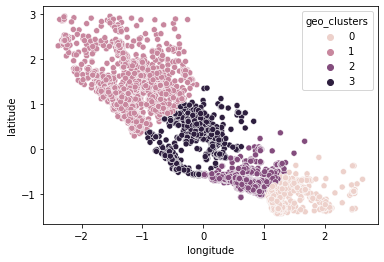

In [24]:
# plot clusters
sns.scatterplot(data=cdts_df, x='longitude', y="latitude", hue=X_scaled.geo_clusters)

#### Encoding geo_clusters feature

In [29]:
# Using get_dummies() pandas method to return a dataframe with clusters as dummy variables.
dummy_geo_clusters = pd.DataFrame(data=pd.get_dummies(X_scaled.geo_clusters).values, columns=['geo_cluster_1', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4'])
print(dummy_geo_clusters)

       geo_cluster_1  geo_cluster_2  geo_cluster_3  geo_cluster_4
0                  0              0              1              0
1                  0              1              0              0
2                  0              0              1              0
3                  0              1              0              0
4                  1              0              0              0
...              ...            ...            ...            ...
16507              1              0              0              0
16508              1              0              0              0
16509              1              0              0              0
16510              0              1              0              0
16511              1              0              0              0

[16512 rows x 4 columns]


In [30]:
# dropping clusters column feature
X_scaled = X_scaled.drop(['geo_clusters'], axis=1)

# merging encoded feature instances into the scaled dataframe
X_scaled = pd.merge(
    left=X_scaled,
    right=dummy_geo_clusters,
    left_index=True,
    right_index=True,
)
X_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4
0,-0.137635,0.534564,-1.795939,-0.357368,-0.156633,-0.032827,-0.218173,-1.258403,0,1,0,0,0,72000.0,0,0,1,0
1,0.879836,-0.909979,-1.637178,-0.276515,-0.449079,-0.494784,-0.417841,1.610623,1,0,0,0,0,274100.0,0,1,0,0
2,-0.312201,0.455091,-0.287715,-0.799127,-0.767468,-0.435204,-0.744572,-1.220425,0,1,0,0,0,58300.0,0,0,1,0
3,0.620480,-0.713633,0.188566,-0.913406,-0.732092,-0.723603,-0.710862,-1.233736,1,0,0,0,0,200000.0,0,1,0,0
4,-0.830911,1.011403,-0.605236,-0.326201,-0.392477,-0.263373,-0.334862,0.114837,0,1,0,0,0,117900.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.165080,1.852884,-0.684616,-0.532626,-0.616528,-0.595810,-0.651220,-0.423409,0,1,0,0,0,93800.0,1,0,0,0
16508,-1.339646,1.161000,1.617410,-0.126100,-0.083522,-0.262510,-0.111856,-0.660681,0,0,0,1,0,103100.0,1,0,0,0
16509,-0.825923,1.539666,-0.763996,-0.051119,-0.184934,-0.197750,-0.187056,0.333675,0,1,0,0,0,192600.0,1,0,0,0
16510,0.710257,-0.685584,0.823608,0.059547,0.708913,0.959301,0.704970,-0.680911,1,0,0,0,0,153500.0,0,1,0,0


We've joined encoded clusters new feature to scaled dataset, which has been created by relating scaled coordinates features to find an optimal k cluster.

### Feature Selection

We'll use PCA dimensional reduction method to perform a feature selection

In [31]:
# defining input features
X = X_scaled.drop("median_house_value", axis=1)

# define covariance matrix
covar_matrix = PCA(n_components = len(X.columns))

# calculate Eigenvalues
covar_matrix.fit(X)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

# cumulate sum of variance explained with [n] features
var=pd.DataFrame(data=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100), columns=['Cumulative variance percentage'])
var

,Cumulative variance percentage
0,41.9
1,66.6
2,78.2
3,87.9
4,91.5
5,94.1
6,95.7
7,96.9
8,98.0
9,99.0


### Feature Permutation

In the above data frame, we notice the first feature explains about 42% of the variance within our data set while the three two explain about 79% and so on.

We'll chose 4 components then.

In [32]:
# Make an instance of chosen components
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

principalComponents = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principalComponents

,PC1,PC2,PC3,PC4
0,-0.107651,0.550652,-0.779945,-2.320683
1,-0.154823,-1.619975,2.072140,-1.042913
2,-1.403125,0.446568,-1.051861,-1.150201
3,-1.423739,-1.371149,-1.042173,-0.245432
4,-0.707171,1.477613,0.335441,-0.842914
...,...,...,...,...
16507,-1.339273,2.169457,-0.047030,-1.160412
16508,-0.948549,1.952088,-0.915670,1.383948
16509,-0.371426,1.859095,0.566734,-0.900217
16510,1.124114,-1.070186,-1.086931,0.968112


#### Hold-out split

In [33]:
# define X, y
X = principalComponents
y = X_scaled["median_house_value"]

# Splitting data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Instantiate Linear regression model

In [40]:
reg_2 = LinearRegression().fit(X_train, y_train)
reg_2.predict(X_test)
# return model's score
round(reg_2.score(X_test, y_test), 2)

0.58

### *Notes*

After a combined feature engineering and feature selection iteration, we decreased model's performance score by 7%, so we'll conclude our baseline model building iteration here, choosing first iteration model's score.

------------------

## Model Export

*Pickle format*

We'll export our best scoring model, which is the one built with our first interaction.

In [9]:
with open('../pickle/model_pickle.pkl', 'wb') as file:
    pickle.dump(reg, file)

----------------